In [1]:
!pip install pyspark py4j

### **Importing necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import os
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

### **Creating spark session and spark context**

In [4]:
spark = SparkSession.Builder().appName("Bitcoin_Analysis").getOrCreate()

In [5]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### **Loading the dataset**

In [6]:
#Loading Data to dataframe
df= sqlContext.read.csv("bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv", header='true', inferSchema='true')
df.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

### **DATA PREPROCESSING**

In [7]:
#getting the schema info from the dataframe
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [8]:
# Count total number of rows
df.count()
# Count the total number of columns
len(df.columns)

8

In [9]:
# creating a temp view table which allows you to query data using SQL syntax.
df.createOrReplaceTempView('bitstampUSD')

# execute an SQL query against the 'bitstampUSD' temporary view using the SQLContext.
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
# The SQL query selects all columns (*) from the 'bitstampUSD' view.
# It converts the 'Timestamp' column to a readable datetime format using the from_unixtime() function, and aliases the result as dateTime.

# Removing null values
bitstampUSD=bitstampUSD.dropna('any')  # The parameter 'any' specifies that any row with at least one null value in any column should be dropped.

In [10]:
bitstampUSD.show()

# Count total number of rows after removing the null values
bitstampUSD.count()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 15:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 16:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 17:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 04:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 15:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 22:45:00|


26449

In [11]:
#Renaming the columns using withColumnRenamed() method
bitstampUSD=bitstampUSD.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [12]:
#Creating another dataframe to perform Datetime Visualization
DateTime_df= bitstampUSD
DateTime_df.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 15:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 16:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 17:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 04:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 15:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 22:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

In [13]:
#Splitting the dataframe by required columns

splitDF = DateTime_df.withColumn("date",split(col("dateTime")," ").getItem(0))
#1.add a new column named "date" to the DataFrame DateTime_df using withCoulumn() method
#2.splits the values in the "dateTime" column using the space (" ") delimiter and select the first part (index 0) of the resulting array

splitDF = splitDF.withColumn("time",split(col("dateTime")," ").getItem(1))
#1.add a new column named "time" to the DataFrame splitDF using withCoulumn() method
#2.splits the values in the "dateTime" column using the space (" ") delimiter and select the index 1 item of the resulting array

splitDF.printSchema()
splitDF.show()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|2011-12-31|07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 15:50:00|2011-12-31|15:50:00|

In [14]:
#Splitting the dataframe by required columns
splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))
splitDFHour.printSchema()
splitDFHour.show()
#1.add a new column named "hour" to the DataFrame splitDF using withCoulumn() method
#2.splits the values in the "time" column using the space (":") delimiter and select the index 1 item of the resulting array which represents hours

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|2011-12-31|07:52:00|  07|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72

In [15]:
#Arranging Dataframe with column date and time and day_of_week

splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime",splitDFHour["dateTime"].cast(DateType()))
# splitDFHour["date"] refers to the "date" column in the DataFrame, and cast(DateType()) converts it to a DateType.
# splitDFHour["hour"] refers to the "hour" column in the DataFrame, and cast(DoubleType()) converts it to a DoubleType.
# splitDFHour["dateTime"] refers to the "dateTime" column in the DataFrame, and cast(DateType()) converts it to a DateType.

splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))
# This line adds a new column named "day_of_week" to the DataFrame splitDFHour.
# The dayofweek() function returns the day of the week (1-7, where 1 is Sunday and 7 is Saturday) from a given date.

splitDFHour.printSchema()
splitDFHour.show(10)

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|07:52:00| 7.0|          7|
|1325

In [16]:
#Arranging Dataframe with column date and time and year

splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
splitDFWithYear.show()
# This line adds a new column named "year" to the DataFrame splitDFHour.
# It extracts the year part from the "date" column by splitting the values using the hyphen ("-") delimiter and selecting the first part (index 0) of the resulting array.

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|07:52:00| 7.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|15:50:00|15.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|16:59:00|16.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|17:00:00|17.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|04:16:00| 4.0|  

### **Converting spark dataframe to pandas dataframe**

In [17]:
# Spark to Pandas dataframe
pandas_converted=splitDFWithYear.toPandas()
pandas_converted.sample(10)

,Timestamp,Open,High,Low,Close,VolBTC,VolCurrency,Weighted_Price,dateTime,date,time,hour,day_of_week,year
2241,1335257520,5.07,5.07,5.07,5.07,203.016206,1029.292163,5.070000,2012-04-24,2012-04-24,08:52:00,8.0,3,2012
10922,1345831440,10.04,10.04,9.87,9.87,73.000000,723.516495,9.911185,2012-08-24,2012-08-24,18:04:00,18.0,6,2012
22218,1353705360,12.11,12.11,12.11,12.11,8.651528,104.770000,12.110000,2012-11-23,2012-11-23,21:16:00,21.0,6,2012
17565,1350668580,11.71,11.71,11.71,11.71,1.069402,12.522695,11.710000,2012-10-19,2012-10-19,17:43:00,17.0,6,2012
3738,1339186560,5.60,5.60,5.60,5.60,24.451112,136.926229,5.600000,2012-06-08,2012-06-08,20:16:00,20.0,6,2012
12185,1346865180,10.33,10.33,10.33,10.33,0.620862,6.413499,10.330000,2012-09-05,2012-09-05,17:13:00,17.0,4,2012
4523,1340174100,6.46,6.46,6.46,6.46,0.226742,1.464756,6.460000,2012-06-20,2012-06-20,06:35:00,6.0,4,2012
25237,1355778960,13.26,13.26,13.26,13.26,0.067873,0.900000,13.260000,2012-12-17,2012-12-17,21:16:00,21.0,2,2012
23454,1354652760,12.85,12.85,12.85,12.85,106.900000,1373.665000,12.850000,2012-12-04,2012-12-04,20:26:00,20.0,3,2012
21469,1353326040,11.40,11.40,11.40,11.40,32.064000,365.529600,11.400000,2012-11-19,2012-11-19,11:54:00,11.0,2,2012


### **DATA VISUALIZATION**

In [18]:
#Getting the values in list so that we can plot and visualize it
hour=pandas_converted["hour"].values.tolist()
weighted_price=pandas_converted["Weighted_Price"].values.tolist()
volume_BTC=pandas_converted["VolBTC"].values.tolist()
date_of_week=pandas_converted["day_of_week"].values.tolist()
year=pandas_converted["year"].values.tolist()

<Axes: >

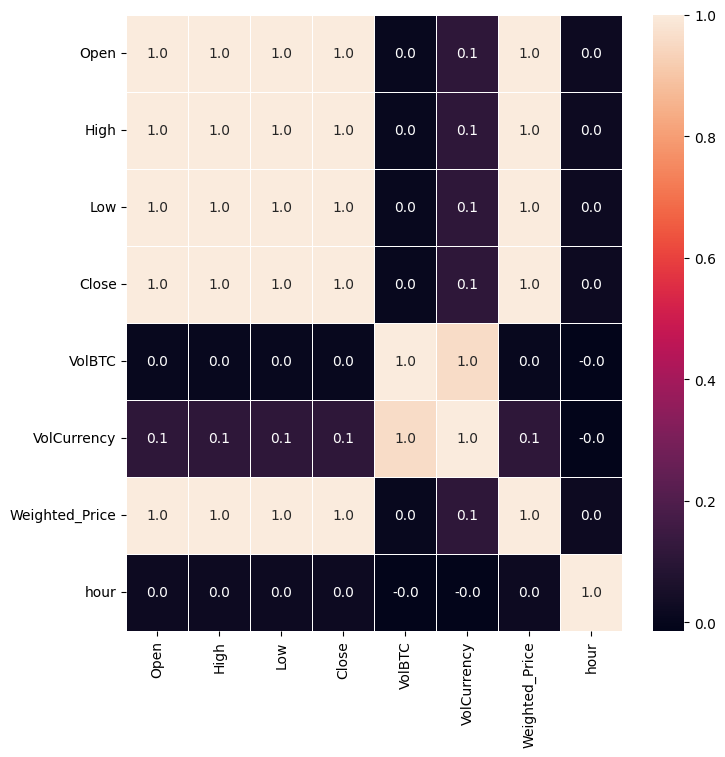

In [19]:
# Drop non-numeric columns
numeric_columns = pandas_converted.select_dtypes(include=['float64', 'int64']).columns
numeric_df = pandas_converted[numeric_columns]

# Calculate correlation matrix
corr = numeric_df.corr()

# Plot heatmap
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.1f',ax=ax) # Creates a heatmap using Seaborn (sns) with the correlation matrix corr. It annotates each cell with its correlation value, sets the line width between cells to 0.5, and formats the annotations to display one decimal place. The heatmap is plotted on the previously defined axis (ax).


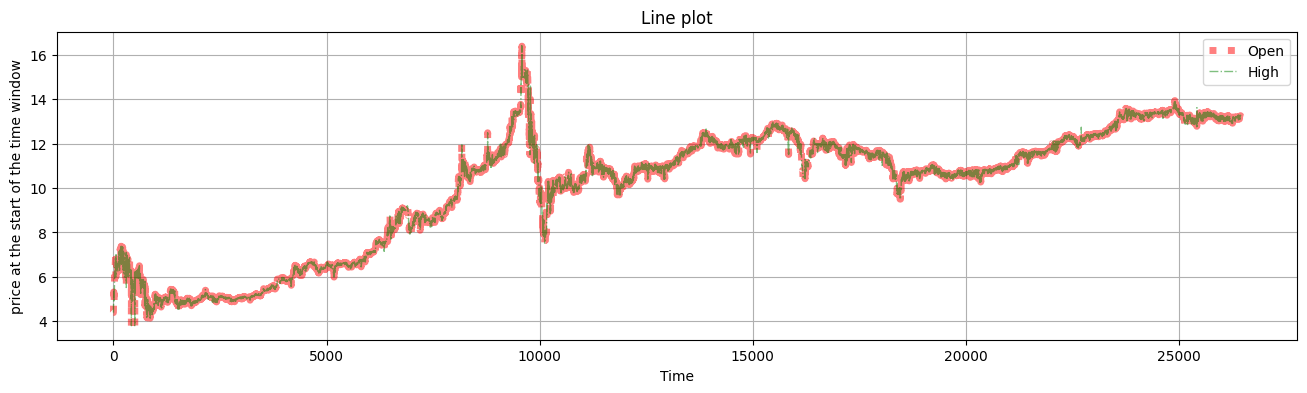

In [20]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind='line', color='r', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandas_converted.High.plot(color='g', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') #legend put label into plot
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Line plot')
plt.show()

#CONCLUSION: there is not much difference in the open and high value which means the peak price during the day is close to the open price duting the day

<Axes: ylabel='Frequency'>

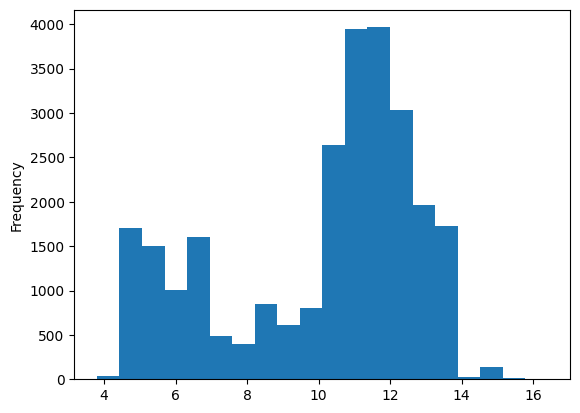

In [21]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind='hist', bins=20)

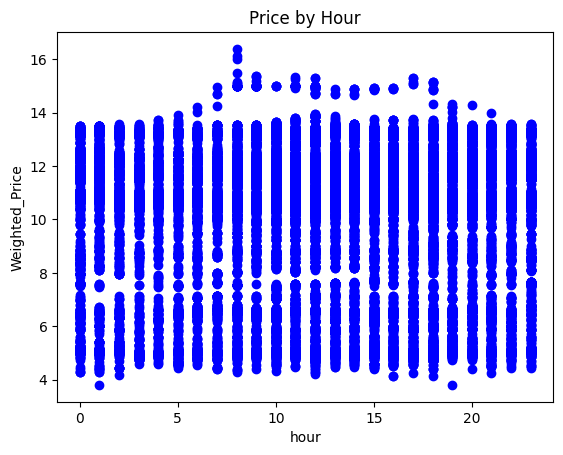

In [22]:
#Plot of Weighted_price per hour in scatter plot using Matplotlib
# scatter plot to visualize the relationship between the hour of the day and the weighted average price of Bitcoin.

plt.plot(hour,weighted_price , 'bo')
plt.xlabel('hour')
plt.ylabel('Weighted_Price')
plt.title('Price by Hour')
plt.show()

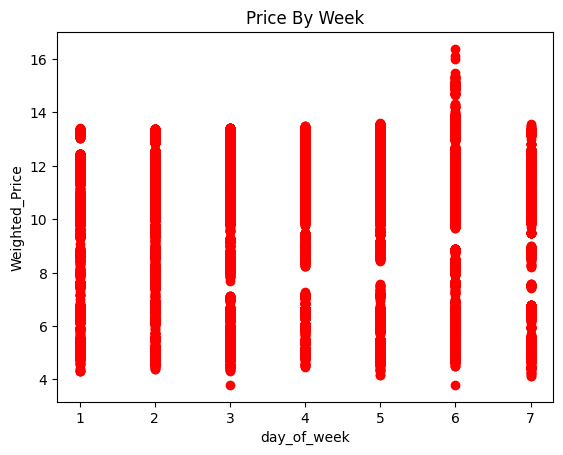

In [23]:
#Plot of Weighted_price per week in scatter plot using Matplotlib
plt.plot(date_of_week, weighted_price, 'ro')
plt.xlabel('day_of_week')
plt.ylabel('Weighted_Price')
plt.title('Price By Week')
plt.show()

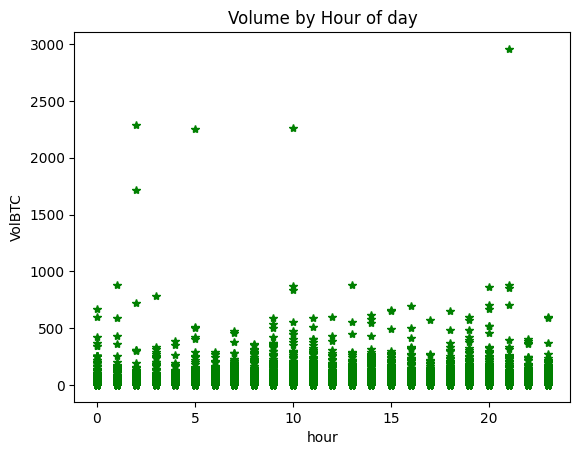

In [24]:
#Plot of VolBTC per hour change displayed in scatter plot using Matplotlib
plt.plot(hour, volume_BTC, 'g*')
plt.xlabel('hour')
plt.ylabel('VolBTC')
plt.title('Volume by Hour of day')
plt.show()

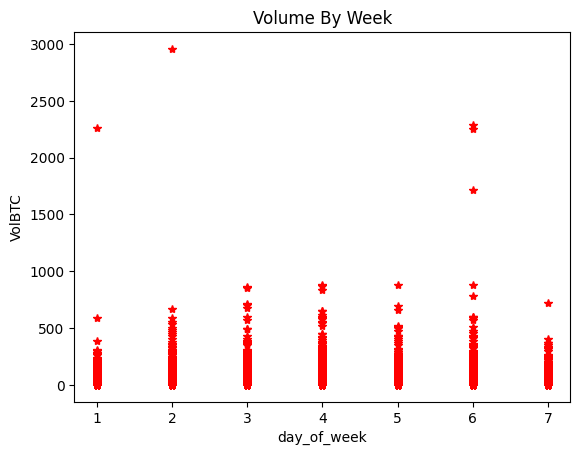

In [25]:
#Plot of VolBTC per day_of_Week change displayed in scatter plot using Matplotlib
plt.plot(date_of_week,volume_BTC , 'r*')
plt.xlabel('day_of_week')
plt.ylabel('VolBTC')
plt.title('Volume By Week')
plt.show()

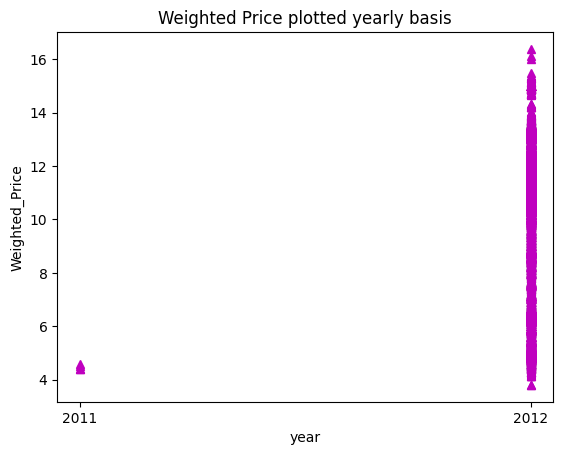

In [26]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,weighted_price , 'm^')
plt.xlabel('year')
plt.ylabel('Weighted_Price')
plt.title('Weighted Price plotted yearly basis')
plt.show()

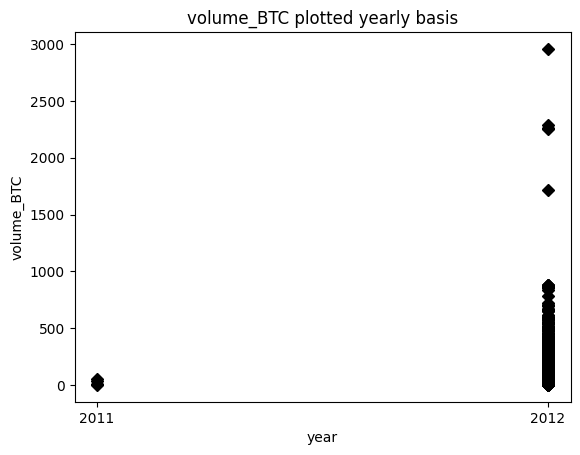

In [27]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,volume_BTC , 'kD')
plt.xlabel('year')
plt.ylabel('volume_BTC')
plt.title('volume_BTC plotted yearly basis')
plt.show()

### **Forming the Feature Vector**

In [28]:
# put features into a feature vector column - feature vector helps us to encode/convert the features into numbers in order to perform machine learning tasks.
assembler = VectorAssembler(inputCols=['Open','High', 'VolBTC', 'VolCurrency','Weighted_Price'], outputCol="features") #The outputCol parameter specifies the name of the new column that will contain the assembled feature vector
assembled_df = assembler.transform(bitstampUSD)
#The transform() method takes the input DataFrame bitstampUSD and generates a new DataFrame assembled_df by assembling the specified input columns into the "features" column using the VectorAssembler.

assembled_df.show(10, truncate= False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                                        |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 07:52:00|[4.39,4.39,0.45558087,2.0000000193,4.39]        |
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 15:50:00|[4.39,4.39,48.0,210.72,4.39]                    |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 16:59:00|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 17:00:00|[4.58,4.58,9.0,41.22,4.58]                      |

### **Feature Scaling**

In [29]:
# Initialize the `Min_Max_scaler`-> scaling is done in order to squish the values between 0 and 1.It is needed in machine learning to ensure that features are on similar scales, which helps algorithms perform optimally and prevents bias in the model.
Min_Max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")


# Fit the DataFrame to the scaler
scaled_df= Min_Max_scaler.fit(assembled_df).transform(assembled_df)
#The fit(assembled_df) method computes summary statistics (min and max) of the feature vectors in the DataFrame to determine how to scale them.
#The transform(assembled_df) method scales the feature vectors in the DataFrame using the computed min-max values.


# Inspect the result
scaled_df.select("features", "scaled_features").show(10, truncate=False)
scaled_df.columns
scaled_df.show(10)

+------------------------------------------------+----------------------------------------------------------------------------------------------------------+
|features                                        |scaled_features                                                                                           |
+------------------------------------------------+----------------------------------------------------------------------------------------------------------+
|[4.39,4.39,0.45558087,2.0000000193,4.39]        |[0.04678826328310864,0.04678826328310864,1.5399165907931323E-4,6.407751948252348E-5,0.04687536608469165]  |
|[4.39,4.39,48.0,210.72,4.39]                    |[0.04678826328310864,0.04678826328310864,0.016224561044029424,0.006751207387529523,0.04687536608469165]   |
|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|[0.0555114988104679,0.06106264869151472,0.012797899014069193,0.005490813405513663,0.05771322866261335]    |
|[4.58,4.58,9.0,41.22,4.58]                      |[0


### **Train Test Split**

In [30]:
# Split the data into train,test and Validation sets
train_data, test_data = scaled_df.randomSplit([.7,.3], seed=134)

### **Linear Regression Model**

In [31]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='scaled_features' , labelCol="Weighted_Price", predictionCol='Predicted_price',
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))
# The regularization parameter, which controls the strength of regularization, A larger value of regParam increases the penalty on the model's coefficients, effectively shrinking them towards zero. This helps prevent the model from over-relying on any single feature and encourages it to find a balance between fitting the training data well and maintaining simplicity.
# The elastic net parameter, which controls the balance between L1 and L2 regularization, A value of 0 corresponds to pure L2 regularization, while a value of 1 corresponds to pure L1 regularization
# A boolean parameter indicating whether to standardize the features before fitting the model (False in this case, as features are already scaled).

In [32]:
# Fit the data to the model
linearModel = lr.fit(train_data)
train_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+--------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|            features|     scaled_features|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+--------------------+--------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|[4.39,4.39,0.4555...|[0.04678826328310...|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 15:50:00|[4.39,4.39,48.0,2...|[0.04678826328310...|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 16:59:00|[4.5,4.57,37.8622...|[0.05551149881046...|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 04:16:00|[4.58,4.58,1.502,...|[0.06185567010309...|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

### **Train data Predictions**

In [33]:
# Generate predictions
predictions = linearModel.transform(train_data)

# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.176603943639786|          4.39|
|7.176603943639786|          4.39|
|7.248990925855452|  4.5264114983|
|7.273369607089619|          4.58|
|7.405785778126233|          4.84|
|7.487272652610303|           5.0|
|7.487272652610303|           5.0|
|7.619688823646915|          5.26|
|7.634967612612678|          5.29|
|7.634967612612678|          5.29|
+-----------------+--------------+
only showing top 10 rows



### **Error in the model**

In [34]:
# Select (predicted_price, Weighted_price label) and compute test error -rmse
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.33267


### **Test Data Predictions**

In [35]:
#Use this model for prediction on test data. Calculate Root Mean Square Error of our model.
predictionsTest = linearModel.transform(test_data)
predictionsTest.select("Predicted_price", "Weighted_Price").show(10)

rmse = evaluator.evaluate(predictionsTest)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 7.273369607089619|          4.58|
| 7.650246401578442|          5.32|
| 7.558573667783863|          5.14|
| 7.634967612612678|          5.29|
| 7.451622145023522|          4.93|
| 7.451622145023522|          4.93|
| 7.584038316060135|          5.19|
| 7.650246401578442|          5.32|
|7.8692423767543795|          5.75|
| 7.880636179902269|   5.777027027|
+------------------+--------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 1.33583


### **Analysing the results**

<ipython-input-36-14e9679b64b0>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
<ipython-input-36-14e9679b64b0>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y, hist=False, color="r", label="Actual Values")
<ipython-inp

<Axes: ylabel='Density'>

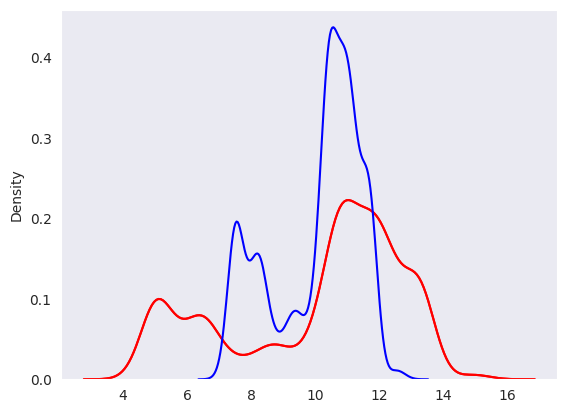

In [36]:
# Use the method "predict" to predict an output on the polynomial features,
# then use the function "DistributionPlot" to display the distribution of the Predicted_Price vs the Weighted_Price from the test data

pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Weighted_Price').toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()
sns.set_style("dark")
ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.set_style("dark")
sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.distplot(_Y, hist=False, color="b", label="Fitted Values")

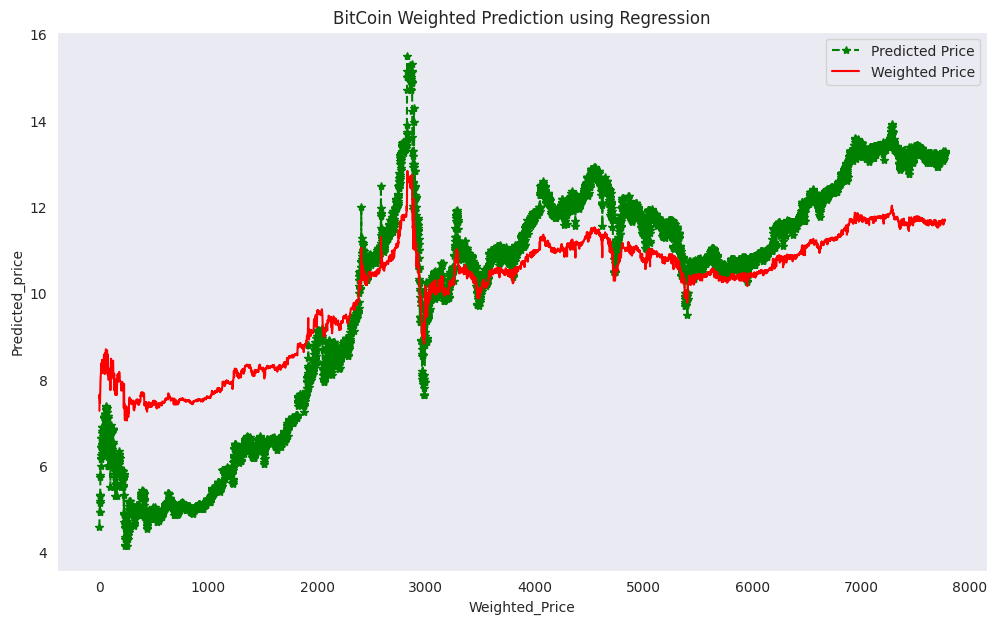

In [37]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed',
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('BitCoin Weighted Prediction using Regression')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()

### **DECISION TREE**

In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Define VectorAssembler to combine features into a single vector
assembler = VectorAssembler(
    inputCols=["Open", "High", "Low", "Close", "VolBTC", "VolCurrency"],
    outputCol="dfeatures")

# Applying VectorAssembler to train_data and test_data
train_datad = assembler.transform(train_data)
test_datad = assembler.transform(test_data)

# Defining DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol="dfeatures", labelCol="Weighted_Price", predictionCol='Predicted_price')

# Training the DecisionTreeRegressor
dt_model = dt.fit(train_datad)

# Making predictions of the test data
predictions_for_tree = dt_model.transform(test_datad)

# Displaying predicted and actual values
predictions_for_tree.select("Predicted_price", "Weighted_Price").show(10)

# Evaluating the model using RMSE error
evaluator = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions_for_tree)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 4.767889311013387|          4.58|
| 5.419015689029823|          5.32|
|5.0509592129067125|          5.14|
| 5.419015689029823|          5.29|
| 4.767889311013387|          4.93|
| 4.767889311013387|          4.93|
| 5.419015689029823|          5.19|
| 5.419015689029823|          5.32|
| 5.419015689029823|          5.75|
| 5.419015689029823|   5.777027027|
+------------------+--------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data = 0.174082


### **Analysing the results**

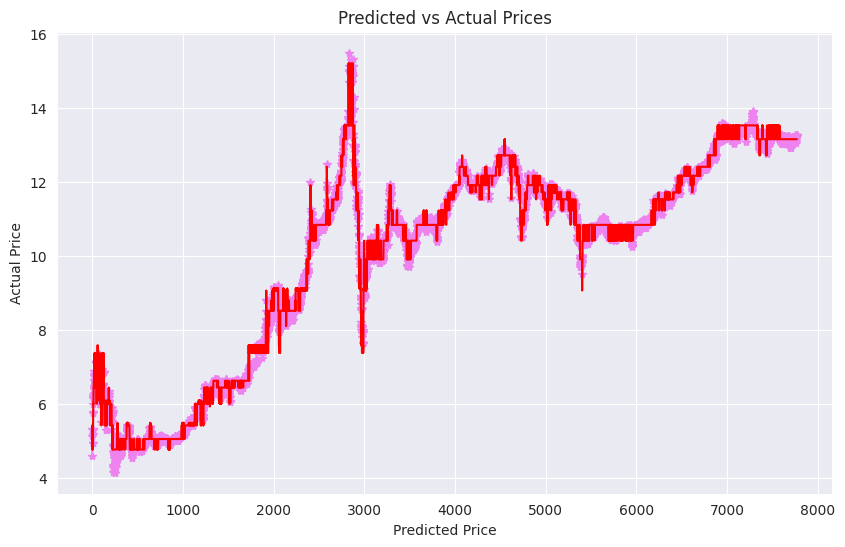

In [39]:
# Convert Spark DataFrame to Pandas DataFrame
Y = predictions_for_tree.select('Weighted_Price').toPandas()
_Y = predictions_for_tree.select("Predicted_price").toPandas()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(Y, color='violet', marker='*', linestyle='dashed',
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.grid(True)
plt.show()


## **RANDOM FOREST**

In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Defining VectorAssembler to combine features into a single vector
assembler = VectorAssembler(
    inputCols=["Open", "High", "Low", "Close", "VolBTC", "VolCurrency"],
    outputCol="dfeatures")

# Applying VectorAssembler to train_data and test_data
train_datad = assembler.transform(train_data)
test_datad = assembler.transform(test_data)

# Defining RandomForestRegressor
rf = RandomForestRegressor(featuresCol="dfeatures", labelCol="Weighted_Price", predictionCol='Predicted_price')

# Training the RandomForestRegressor
rf_model = rf.fit(train_datad)

# Making predictions on the test data
predictions_for_rf = rf_model.transform(test_datad)

# Displaying predicted and actual values
predictions_for_rf.select("Predicted_price", "Weighted_Price").show(10)

# Defining RegressionEvaluator with the correct metricName
evaluator = RegressionEvaluator(labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")

# Evaluating the model using RMSE
rmse_rf = evaluator.evaluate(predictions_for_rf)
print("Root Mean Squared Error (RMSE) on test data for Random Forest = %g" % rmse_rf)


+------------------+--------------+
|   Predicted_price|Weighted_Price|
+------------------+--------------+
| 4.785631717738024|          4.58|
| 5.244220885756858|          5.32|
| 5.245830161501955|          5.14|
| 5.244220885756858|          5.29|
| 4.930313003101163|          4.93|
|4.9296531403587895|          4.93|
| 5.258249932321148|          5.19|
| 5.240765329703745|          5.32|
| 5.858273840303636|          5.75|
| 5.854645662382843|   5.777027027|
+------------------+--------------+
only showing top 10 rows

Root Mean Squared Error (RMSE) on test data for Random Forest = 0.160666


### **Analyzing the results**

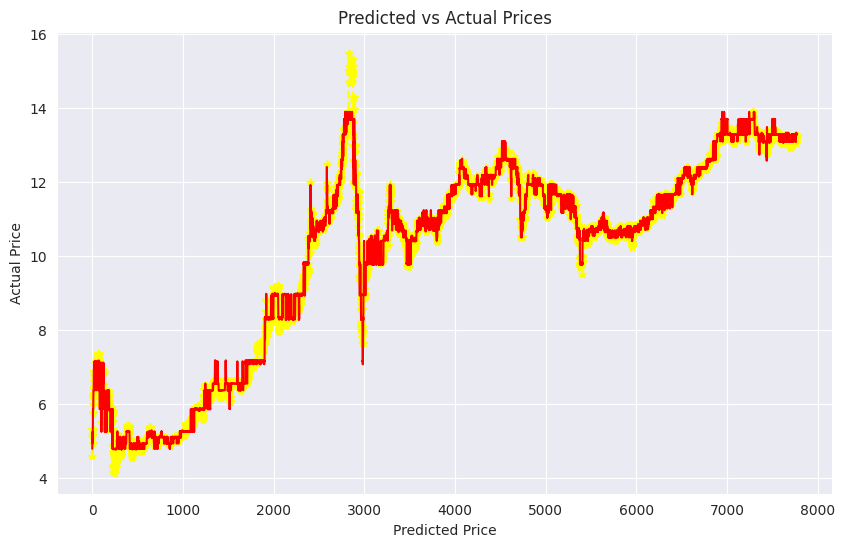

In [41]:
# Convert Spark DataFrame to Pandas DataFrame
Y = predictions_for_rf.select('Weighted_Price').toPandas()
_Y = predictions_for_rf.select("Predicted_price").toPandas()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(Y, color='yellow', marker='*', linestyle='dashed',
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.grid(True)
plt.show()


### **Making final dataset for Power BI analysis**

In [61]:
# Create Pandas DataFrame for original data
original_data = splitDFWithYear.toPandas()

# Create Pandas DataFrame for predictions on test data
predictions_df = pd.DataFrame({
    "LinearRegression_Predictions": predictions.select("Predicted_price").toPandas()["Predicted_price"],
    "DecisionTree_Predictions": predictions_for_tree.select("Predicted_price").toPandas()["Predicted_price"],
    "RandomForest_Predictions": predictions_for_rf.select("Predicted_price").toPandas()["Predicted_price"]
})

# Concatenate original data DataFrame and predictions DataFrame horizontally
result_df = pd.concat([original_data, predictions_df], axis=1)

# Display the resulting DataFrame
print(result_df)

result_df.to_csv('dataset_with_predictions.csv')


        Timestamp   Open   High    Low  Close     VolBTC  VolCurrency  \
0      1325317920   4.39   4.39   4.39   4.39   0.455581     2.000000   
1      1325346600   4.39   4.39   4.39   4.39  48.000000   210.720000   
2      1325350740   4.50   4.57   4.50   4.57  37.862297   171.380338   
3      1325350800   4.58   4.58   4.58   4.58   9.000000    41.220000   
4      1325391360   4.58   4.58   4.58   4.58   1.502000     6.879160   
...           ...    ...    ...    ...    ...        ...          ...   
26444  1356779760  13.26  13.26  13.26  13.26  11.255656   149.250000   
26445  1356783000  13.22  13.22  13.22  13.22   1.053707    13.930000   
26446  1356786060  13.26  13.26  13.26  13.26   9.212670   122.160000   
26447  1356799500  13.24  13.24  13.24  13.24   4.015757    53.168625   
26448  1356808320  13.24  13.24  13.24  13.24  20.000000   264.800000   

       Weighted_Price    dateTime        date      time  hour  day_of_week  \
0            4.390000  2011-12-31  2011-12-31